In [1]:
import config as c
import utils as u

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_context("notebook", rc={"font.size": 18, "axes.titlesize": 18, "axes.labelsize": 16, "axes.titleweight": "bold", "xtick.labelsize": 13, "ytick.labelsize": 13, "lines.linewidth": 2, "lines.markersize": 7})
%load_ext autoreload
%autoreload 2

TODO- determine n days training at switch for each one of these- more rig switches could be due to more time training and things breaking.

- R046- moved due to speaker breaking on aug 3rd after 4 days in grow fix

  - not concerning of an effect

- R048- moved to left port breaking on aug 28th after 20 days in grow fix

  - does get kinda better after rig shift but it takes at least a week to grow out of max, not too concerning

- R052- moved due to low trial counts on sep 28th after 32 days in grow fix, rather than being mid 3s, were low to mid 2s sometimes 1s

  - did succeed after rig switch, maybe due to it

- R054- moved due to cpoking not happening on aug 13th after 5 days of < 10 trials at the start of cpoke growth

  - not concerning of an effect

- R056- moved due to rig freezing occasionally in later sessions after 32 days
  - not concerning of an effect


# 0. Load Data


In [2]:
tdf = u.load_trials_df(stages="all")
tdf["date"] = pd.to_datetime(tdf["date"])
ddf = u.load_days_df(stages="all")

Loading days data from directory: /Users/jessbreda/Desktop/github/jbreda_animal_training/notebooks/fixation_publication
Loading days data from directory: /Users/jessbreda/Desktop/github/jbreda_animal_training/notebooks/fixation_publication


In [3]:
trial_rig_df = pd.merge(
    tdf,
    ddf[["animal_id", "stage", "date", "rigid"]],
    on=["animal_id", "stage", "date"],
)
trial_rig_df = u.compute_days_relative_to_stage(trial_rig_df, stage=5)

In [4]:

def plot_fixation_with_events_and_violations(ax, df, experiment):
    """
    ax          : the matplotlib Axes to draw on
    df          : subset of trial_rig_df for one animal
    experiment  : either "V1" or "V2"
    """
    # 1) choose fixation‐curve color
    fix_color = c.V1_COLOR if experiment == "V1" else c.V2_COLOR

    # 2) plot max fixation duration
    sns.lineplot(
        data=df,
        x="days_relative_to_stage_5",
        y="fixation_dur",
        estimator="max",
        ax=ax,
        marker="o",
        color=fix_color,
    )
    ax.axhline(y=2, color="k", linewidth=1)
    ax.set(ylim=(-0.1, 2.5), xlabel="Days in Fixation Growth Curriculum")
    ax.set_ylabel("Max Fix Dur [s]", color=fix_color, weight="semibold")

    # 3) detect rigid↔non‐rigid switches & draw vertical lines
    df_sorted = df.sort_values("days_relative_to_stage_5")
    changes = df_sorted["rigid"].ne(df_sorted["rigid"].shift())
    for day in df_sorted.loc[changes, "days_relative_to_stage_5"].unique():
        if day != 0:
            ax.axvline(x=day, color="darkgray", linestyle="--", alpha=0.7)

    # 4) overlay violation rate on a second y‐axis
    ax2 = ax.twinx()
    if experiment == "V1":
        # V1 already has a "violations" column
        sns.lineplot(
            data=df,
            x="days_relative_to_stage_5",
            y="violations",
            color=c.VIOLATION_COLOR,
            ax=ax2,
            marker="o",
            linestyle="--",
            errorbar=None,
        )
    else:
        # V2: compute 1 - (#trials / sum(n_settling_ins)) per day
        grouped = (
            df.groupby("days_relative_to_stage_5")
              .agg(
                n_trials=("animal_id", "size"),
                n_settling=("n_settling_ins", "sum")
              )
              .reset_index()
        )
        grouped["violation_rate"] = 1 - grouped["n_trials"] / grouped["n_settling"]
        sns.lineplot(
            data=grouped,
            x="days_relative_to_stage_5",
            y="violation_rate",
            color=c.VIOLATION_COLOR,
            ax=ax2,
            marker="o",
            linestyle="--",
            errorbar=None,
        )

    ax2.set_ylabel("Violation Rate", color=c.VIOLATION_COLOR, weight="semibold")
    ax2.set_ylim(0, 1)

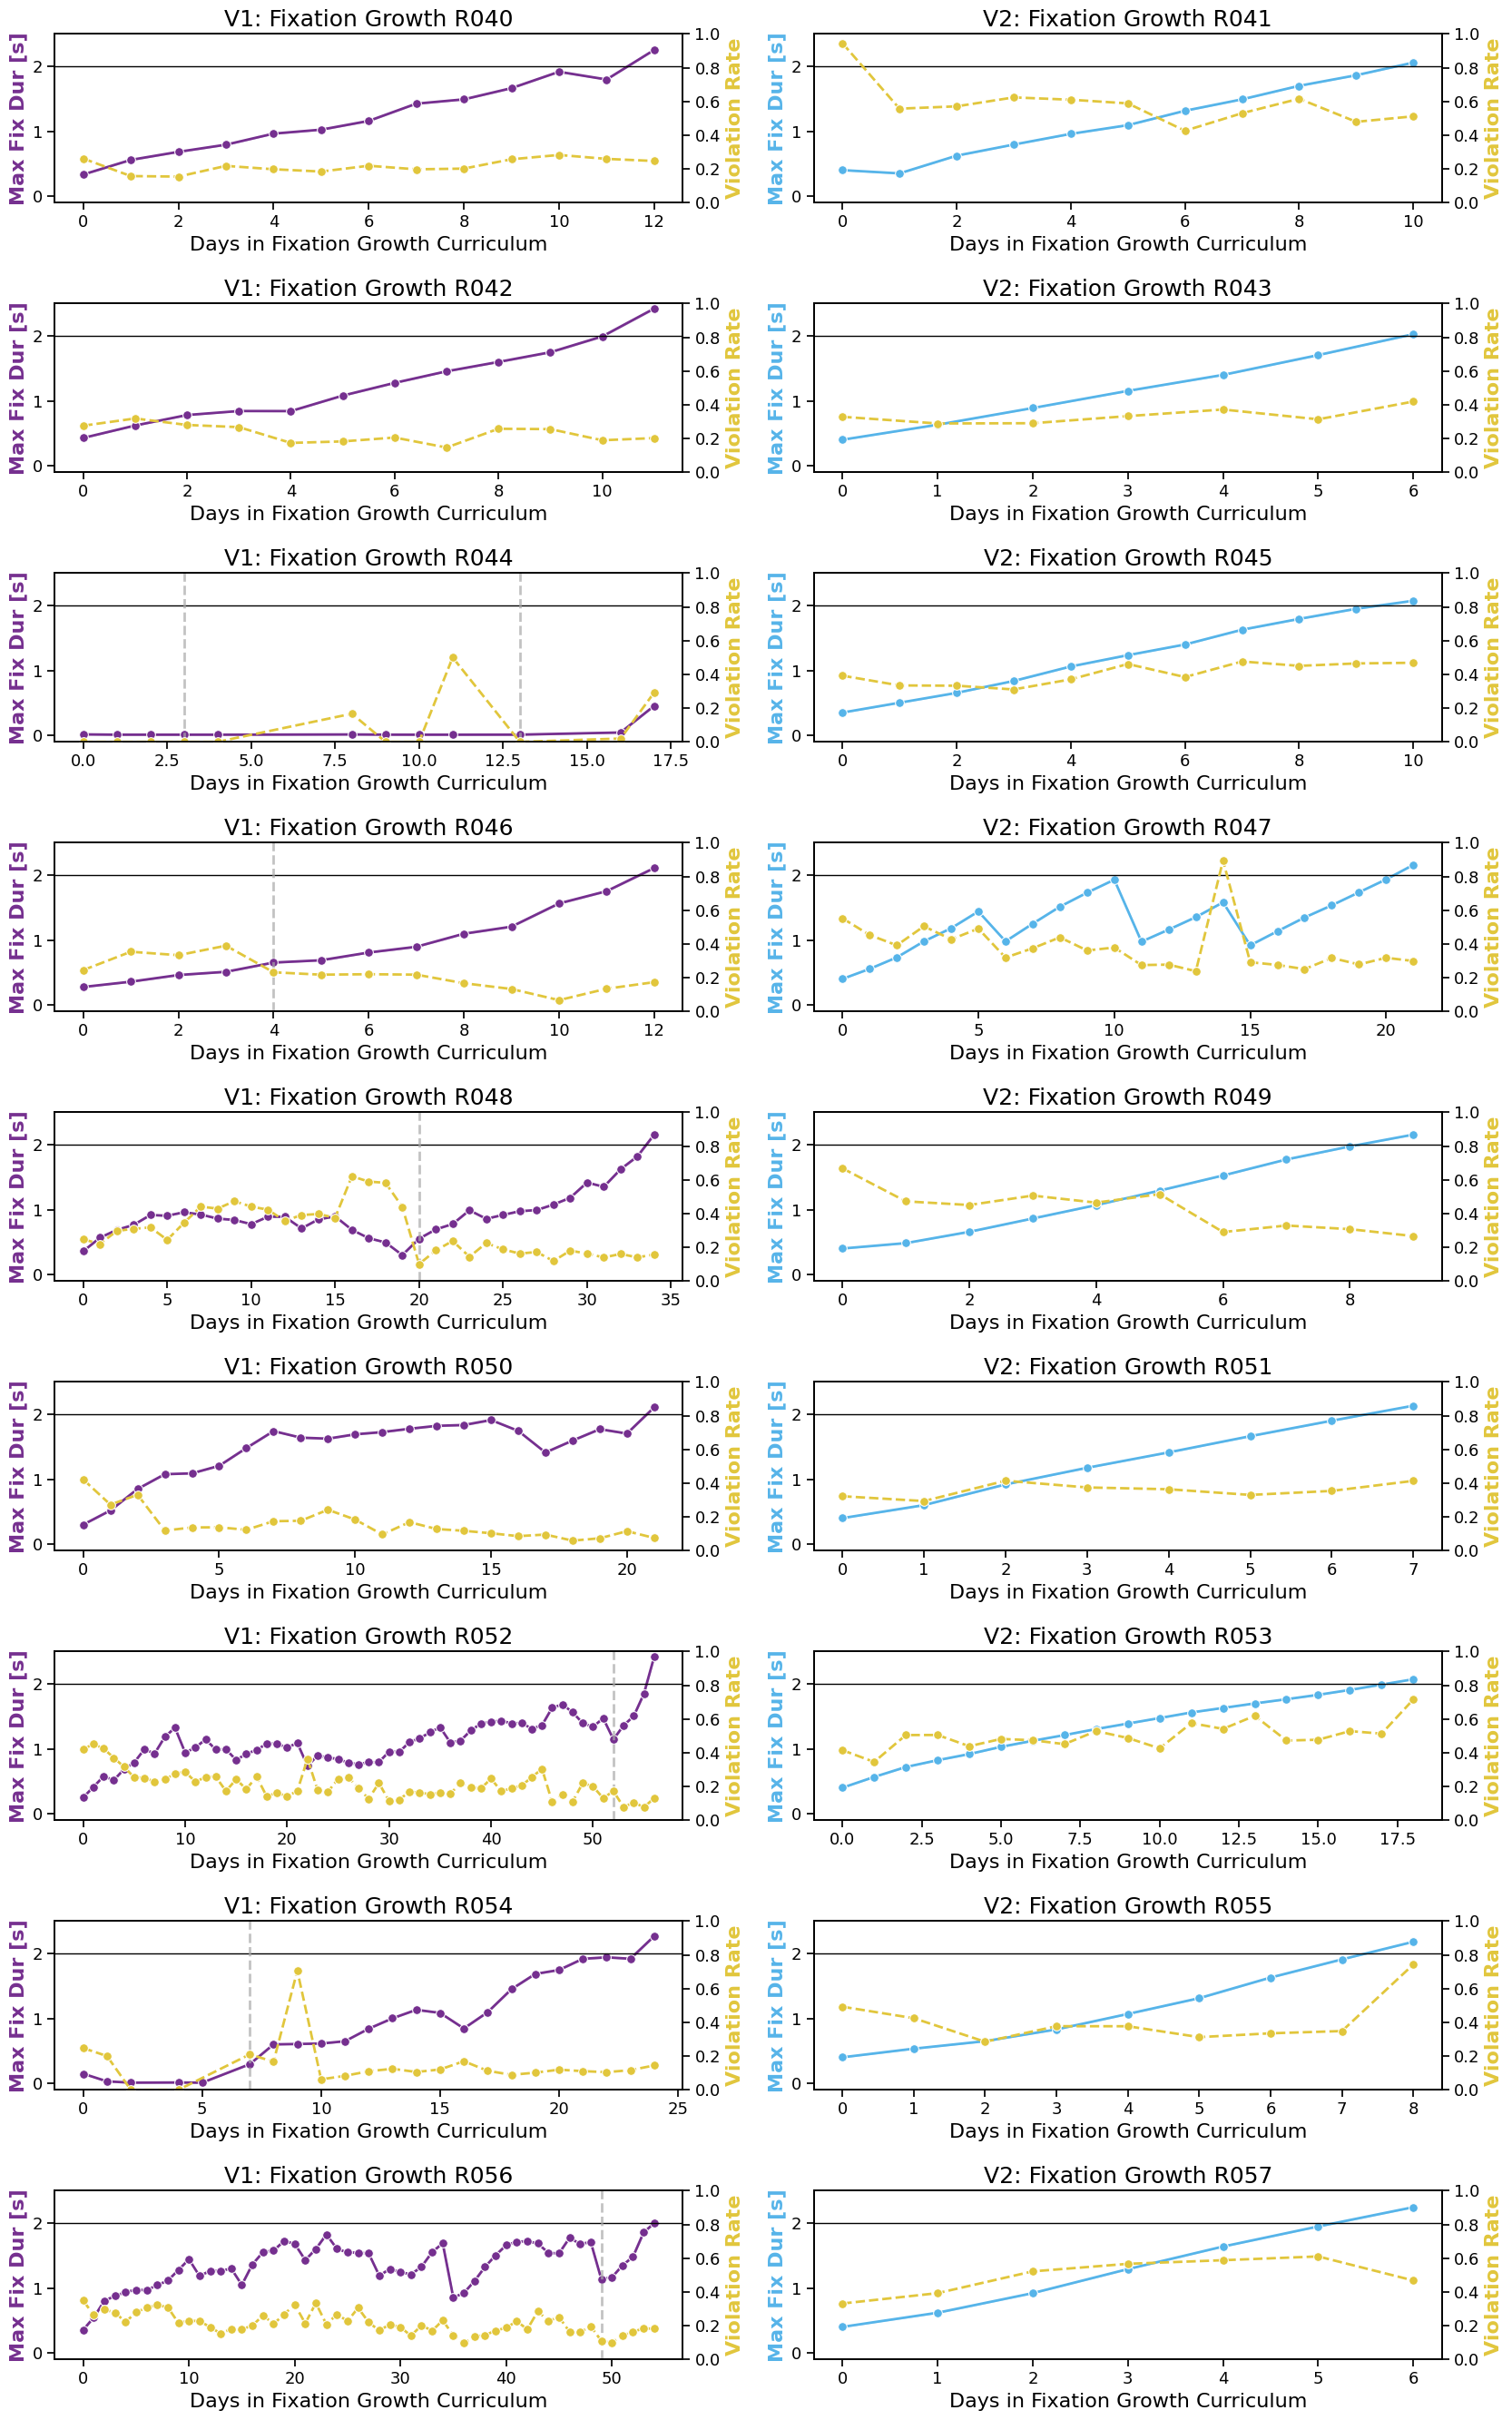

In [5]:

n_rows = len(c.V1_ANIMALS)
n_cols = 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(17, 3 * n_rows))

# V1
for row, animal in enumerate(c.V1_ANIMALS):
    df = trial_rig_df.query(
        "fix_experiment == 'V1' and stage > 4 and stage < 8 and animal_id == @animal"
    )
    ax = axs[row, 0]
    plot_fixation_with_events_and_violations(ax, df, "V1")
    ax.set_title(f"V1: Fixation Growth {animal}")

# V2
for row, animal in enumerate(c.V2_ANIMALS):
    df = trial_rig_df.query(
        "fix_experiment == 'V2' and stage > 4 and stage < 8 and animal_id == @animal"
    )
    ax = axs[row, 1]
    plot_fixation_with_events_and_violations(ax, df, "V2")
    ax.set_title(f"V2: Fixation Growth {animal}")

plt.tight_layout()
plt.show()

c.save_fig(fig, "fig_S3_raw_fix_rig_viol_data")